# Word Segmentation with CNN

In [1]:
from platform import python_version

print(python_version())

3.7.9


## Library and class definition

### Import library

In [2]:
!pip install tf2crf
# https://pypi.org/project/tf2crf/

  Using cached numpy-1.19.5-cp37-cp37m-macosx_10_9_x86_64.whl (15.6 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.20.2
    Uninstalling numpy-1.20.2:
      Successfully uninstalled numpy-1.20.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pyldavis 3.3.1 requires numpy>=1.20.0, but you have numpy 1.19.5 which is incompatible.
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


In [3]:
import json
import numpy as np
from collections import OrderedDict
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tf2crf import CRF, ModelWithCRFLoss
import matplotlib.pyplot as plt

### Define Text_Processor class

In [4]:
class Text_Processor:
    '''
    Class for word tokenization and model training task
    parameters:
        chr2vec_dic_path: character embedding dictionary path
        model_path: path of model file, model has to be trained frist if path is not provided
        sentence_size: max size of charater per sentence
        overlap: overlap size (overlap size should be greater than or equal to number of convolutional layers)
    
    attributes:
        model: word segmentation model
        crf: crf model flag (for new implementation)
        sentence_size: max size of charater per sentence
        overlap: overlap size (overlap size should be greater than or equal to number of convolutional layers)
        ndim: inout dimension
        look_up_dict: look up dict for character id
        chr_size: number of character in dict
        chr_vec_size: character embedding size
        embedding_matrix: look up table for chracter embedding vector
    
    methods: **we have 2 create_model for complatibility
        create_model_sigmoid: create new cnn word segmentation model using sigmoid
            conv_layer: number of convolutional layers
            conv_chanel: channel per layer
            kernel: kernel size
            dropout_rate: drop out rate per layer
            
        create_model_crf: create new cnn word segmentation model using crf
            conv_layer: number of convolutional layers
            conv_chanel: channel per layer
            kernel: kernel size
            dropout_rate: drop out rate per layer
            glu: if True then use gate linear unit in conv layer else use relu
            
        save_model: save current model
            path: model path
            
        load_model: load model
            path: model path
            
        text_to_x_y: transform text into data for train and test
            text: input text
            sep: word seperator character 
        return X, Y, dim
            
        text_to_x: transform text into data for word segmentation task
            text: input text
        return X, dim
        
        word_tagging: tag text with word seperator
            text: input text
            model: word segmentation model, if model is not provided this method will use self.model
            sep: word seperator character  
            theshold: theshold of predicted values
        return segmented string with word seperator
        
        word_tokenizer: split text into list of words
            text: input text
            model: word segmentation model, if model is not provided this method will use self.model
            theshold: theshold of predicted values
        return list of words
        
        get_eval: get evaluation score
            text: input list of text
            theshold: assignment theshold (only use if model require it)
            model: word segmentation model, if model is not provided this method will use self.model
        return {'char_level': {'precision', 'recall', 'f1'}, 'word_level': {'precision', 'recall', 'f1'}}
        
    '''
    def __init__(self, chr2vec_dic_path, model_path=None, crf=False, **kwargs):
        
        '''init parameters'''
        self.crf = crf
        self.sentence_size = kwargs.get('sentence_size', 100)
        self.overlap = kwargs.get('overlap', 5)
        self.ndim = self.sentence_size + self.overlap*2
        
        '''create look up dict and embedding matrix'''
        self.look_up_dict = OrderedDict()
        self.look_up_dict['<pad>'] = 0
        with open(chr2vec_dic_path,'r', encoding="utf-8") as f:
            for k,v in json.load(f).items():
                self.look_up_dict[k] = [float(i) for i in v]
        self.chr_size = len(self.look_up_dict)
        self.chr_vec_size = len(list(self.look_up_dict.values())[1])
        self.look_up_dict['<pad>'] = np.zeros(self.chr_vec_size)
        self.embedding_matrix = np.zeros((self.chr_size, self.chr_vec_size), dtype=np.float32)
        for i, (k, v) in enumerate(self.look_up_dict.items()):
            self.embedding_matrix[i, :] = v
            self.look_up_dict[k] = i
        
        '''load model'''
        if self.crf and model_path is not None:
            '''for crf we have to load weight instead (bug)'''
            self.load_model(model_path, 
                            crf = crf,
                            conv_layer = kwargs.get('conv_layer', 5),
                            conv_chanel = kwargs.get('conv_chanel', 100),
                            kernel = kwargs.get('kernel', 3),
                            dropout_rate = kwargs.get('dropout_rate', 0.2),
                            glu = kwargs.get('glu', True)
                           )
        else:
            self.model = None if model_path is None else models.load_model(model_path)
            
    def create_model_sigmoid(self, conv_layer=5, conv_chanel=50, kernel=3, dropout_rate=0.2):
        
        '''create new model and add layers'''
        self.model = models.Sequential()
        self.model.add(layers.InputLayer(input_shape=(self.ndim)))
        self.model.add(layers.Embedding(self.chr_size, 
                                        self.chr_vec_size, 
                                        weights=[self.embedding_matrix], 
                                        trainable=False))
        self.model.add(layers.Dropout(dropout_rate))
        
        '''create convolutional layers'''
        for i in range(conv_layer):
            self.model.add(layers.Conv1D(conv_chanel, 
                                         kernel, 
                                         activation='relu', 
                                         padding='same'))
            self.model.add(layers.Dropout(dropout_rate))
        
        self.model.add(layers.Dense(1, activation='sigmoid'))
        self.model.compile(optimizer='adam',
                           loss='binary_crossentropy',
                           metrics=['binary_accuracy'])
        self.crf = False
    
    def create_model_crf(self, conv_layer=5, conv_chanel=100, kernel=3, dropout_rate=0.2, glu = True):
        x = layers.Input(shape=(self.ndim))
        y = layers.Embedding(self.chr_size, 
                             self.chr_vec_size, 
                             weights=[self.embedding_matrix], 
                             trainable=False)(x)
        y = layers.Dropout(dropout_rate)(y)
        
        '''create convolutional layers'''
        if glu:
            for i in range(conv_layer):
                y1 = layers.Conv1D(conv_chanel, kernel, padding='same')(y)
                y2 = layers.Conv1D(conv_chanel, kernel, activation='sigmoid', padding='same')(y)
                y = layers.Multiply()([y1,y2])
                y = layers.Dropout(dropout_rate)(y)
        else:
            y = layers.Conv1D(conv_chanel, kernel, activation='relu', padding='same')(y)
            y = layers.Dropout(dropout_rate)(y)
            
        y = layers.Dense(16, activation=None)(y)
        y = CRF(dtype='float32')(y)
        self.model = ModelWithCRFLoss(models.Model(x, y))
        self.model.compile(optimizer='adam')
        self.crf = True
        
    
    def save_model(self, path):
        self.model.save(path)
    
    def load_model(self, path, crf=False, **kwargs):
        if self.crf:
            self.create_model_crf(conv_layer = kwargs.get('conv_layer', 5),
                                  conv_chanel = kwargs.get('conv_chanel', 100),
                                  kernel = kwargs.get('kernel', 3),
                                  dropout_rate = kwargs.get('dropout_rate', 0.2),
                                  glu = kwargs.get('glu', True)
                                 )
            self.model.load_weights(path+'/variables/variables')
            self.crf = True
        else:
            self.model = models.load_model(path)
            self.crf = False
    
    def x_y_transformer(self, text, sep='|'):
        
        '''assign x_id , y_values from input text'''
        inputs_value = list()
        outputs_value = list()
        for word in text.split(sep):
            if len(word) == 0:
                continue
            outputs_value = outputs_value + [1] + [0]*(len(word) - 1)
            for char in word:
                if char == '\n':
                    inputs_value.append(self.look_up_dict['<pad>'])
                elif char not in self.look_up_dict.keys():
                    inputs_value.append(self.look_up_dict['<unk>'])
                else:
                    inputs_value.append(self.look_up_dict[char])
        assert len(inputs_value) == len(outputs_value), str(len(inputs_value))+' '+str(len(outputs_value))
        
        '''split value into sentence size list'''
        char_size = len(outputs_value)
        left_over = char_size%self.sentence_size
        n_chunk = char_size//self.sentence_size
        inputs = []
        outputs = []
        ret_dim = []
        for i in range(1, n_chunk+1+(left_over>0)):
            
            '''add overlap values if no value before or after, add <pad> values'''
            if i == 1:
                inputs_before = [self.look_up_dict['<pad>']]*self.overlap
                outputs_before = [0]*self.overlap
            else:
                inputs_before = inputs_value[(i-1)*self.sentence_size-self.overlap:(i-1)*self.sentence_size]
                inputs_before = inputs_before + [self.look_up_dict['<pad>']]*(self.overlap-len(inputs_before))
                outputs_before = outputs_value[(i-1)*self.sentence_size-self.overlap:(i-1)*self.sentence_size]
                outputs_before = outputs_before + [0]*(self.overlap-len(outputs_before))
            
            if i == n_chunk+1:
                inputs_after = [self.look_up_dict['<pad>']]*(self.sentence_size-left_over+self.overlap)
                outputs_after = [0]*(self.sentence_size-left_over+self.overlap)
            else:
                inputs_after = inputs_value[i*self.sentence_size:i*self.sentence_size+self.overlap]
                inputs_after = inputs_after + [self.look_up_dict['<pad>']]*(self.overlap-len(inputs_after))
                outputs_after = outputs_value[i*self.sentence_size:i*self.sentence_size+self.overlap]
                outputs_after = outputs_after + [0]*(self.overlap-len(outputs_after))
            
            '''combline before + sentence size char vector + after'''
            inputs.append(inputs_before
                          + inputs_value[(i-1)*self.sentence_size:i*self.sentence_size]
                          + inputs_after
                         )
            outputs.append(outputs_before
                          + outputs_value[(i-1)*self.sentence_size:i*self.sentence_size]
                          + outputs_after
                         )
            d = self.overlap + left_over if i == n_chunk+1 else self.overlap + self.sentence_size
            ret_dim.append((self.overlap, d))
            
        return inputs, outputs, ret_dim
    
    def x_transformer(self, text):
        
        '''assign x_id from input text'''
        inputs_value = list()
        for char in text:
            if char == '\n':
                inputs_value.append(self.look_up_dict['<pad>'])
            elif char not in self.look_up_dict.keys():
                inputs_value.append(self.look_up_dict['<unk>'])
            else:
                inputs_value.append(self.look_up_dict[char])
                
        '''split value into sentence size list'''
        char_size = len(inputs_value)
        left_over = char_size%self.sentence_size
        n_chunk = char_size//self.sentence_size
        inputs = []
        ret_dim = []
        for i in range(1, n_chunk+1+(left_over>0)):
            
            '''add overlap values if no value before or after, add <pad> values'''
            if i == 1:
                inputs_before = [self.look_up_dict['<pad>']]*self.overlap
            else:
                inputs_before = inputs_value[(i-1)*self.sentence_size-self.overlap:(i-1)*self.sentence_size]
                inputs_before = inputs_before + [self.look_up_dict['<pad>']]*(self.overlap-len(inputs_before))

            if i == n_chunk+1:
                inputs_after = [self.look_up_dict['<pad>']]*(self.sentence_size-left_over+self.overlap)
            else:
                inputs_after = inputs_value[i*self.sentence_size:i*self.sentence_size+self.overlap]
                inputs_after = inputs_after + [self.look_up_dict['<pad>']]*(self.overlap-len(inputs_after))
            
            '''combline before + sentence size char vector + after'''
            inputs.append(inputs_before
                          + inputs_value[(i-1)*self.sentence_size:i*self.sentence_size]
                          + inputs_after
                         )
            d = self.overlap + left_over if i == n_chunk+1 else self.overlap + self.sentence_size
            s = i == n_chunk+1
            ret_dim.append((self.overlap, d, s))
        
        return inputs, ret_dim
    
    def text_to_x_y(self, text, sep='|'):
        X_list = []
        Y_list = []
        ret_dim = []
        if type(text) is list or type(text) is tuple:
            text = '\n'.join(text)
            
        if type(text) is str and len(text.split('\n')) > 0:
            text = text.split('\n')
            for l in text:
                l = l.strip(sep)
                if len(l) == 0:
                    continue
                X, Y, r = self.x_y_transformer(l, sep)
                X_list.extend(X)
                Y_list.extend(Y)
                ret_dim.extend(r)
        elif type(text) is str:
            X, Y, r = self.x_y_transformer(text, sep)
            X_list.extend(X)
            Y_list.extend(Y)
            ret_dim.extend(r)
        else:
            raise AttributeError('text is not a list nor str')
        X_list = np.array(X_list, dtype=np.int32)    
        Y_list = np.array(Y_list, dtype=np.int32)
        if len(X_list.shape) == 1:
            X_list = X_list.reshape(1, X_list.shape[0])
            Y_list = Y_list.reshape(1, Y_list.shape[0])
        
        return X_list, Y_list, ret_dim
    
    def text_to_x(self, text):
        X_list = []
        ret_dim = []
            
        if type(text) is list or type(text) is tuple:
            for l in text:
                X, r = self.x_transformer(l)
                X_list.extend(X)
                ret_dim.extend(r)
        elif type(text) is str:
            X, r = self.x_transformer(text)
            X_list.extend(X)
            ret_dim.extend(r)
        else:
            raise AttributeError('text is not a list nor str')
        X_list = np.array(X_list, dtype=np.int32)    
        if len(X_list.shape) == 1:
            X_list = X_list.reshape(1, X_list.shape[0])
        
        return X_list, ret_dim
        
    def word_tagging(self, text, model=None, sep='|', theshold=0.5):
        
        '''type check'''
        flag = False
        if type(text) is list or type(text) is tuple:
            flag = True
        elif type(text) is not str:
            raise AttributeError('this method only accept string of text')
            
        '''feed to model'''
        model = self.model if model is None else model
        X, dim = self.text_to_x(text)
        
        if X.shape[0] < 256 or len(tf.config.list_physical_devices('GPU')) == 0:
            with tf.device('/cpu:0'):
                Y = model.predict(X)[0] if self.crf else model.predict(X)
        else:
            with tf.device('/gpu:0'):
                Y = model.predict(X, batch_size=1024)[0] if self.crf else model.predict(X, batch_size=1024)
        
        '''process word filter vector'''
        size = X.shape[0]
        word_filter = []
        sent_filter = []
        for i in range(size):
            word_filter.extend(Y[i, dim[i][0]: dim[i][1]].flatten().tolist())
            s = [False]*(dim[i][1]-dim[i][0])
            s[-1] = dim[i][2]
            sent_filter.extend(s)
        
        '''add saperator character'''
        seg_text = ''
        prev_char = ''
        if flag:
            text = ''.join(text)
        for char, fil, s in zip(text, word_filter, sent_filter):
            seg_text += sep if fil > theshold or char == '\n' or prev_char == '\n' else ''
            seg_text += char
            seg_text += '<?/cut>' if s and flag else ''
            prev_char = char
        
        if flag:
            temp = []
            for s in seg_text.split('<?/cut>'):
                if len(s) > 0 and s != sep:
                    s += sep if s[-1] != sep else ''
                    temp.append(s)
            seg_text = temp
        else:
            seg_text += sep
                    
        return seg_text
    
    def word_tokenizer(self, text, model=None, theshold=0.5):
        seg_text = self.word_tagging(text, model, '|', theshold)
        return seg_text.strip('|').split('|')
    
    def get_eval(self, text, theshold=0.5, model=None, sep='|', frankenstein=False):
        model = self.model if model is None else model
                
        X, Y, dim = self.text_to_x_y(text, sep=sep)
        X = np.array(X, dtype=np.int32)
        Y = np.array(Y, dtype=np.int32)
        
        if len(X.shape) == 1:
            X = X.reshape(1, X.shape[0])
            Y = Y.reshape(1, Y.shape[0])
        
        if X.shape[0] < 256 or len(tf.config.list_physical_devices('GPU')) == 0:
            with tf.device('/cpu:0'):
                Y_hat = model.predict(X)[0] if self.crf else model.predict(X)
        else:
            with tf.device('/gpu:0'):
                Y_hat = model.predict(X, batch_size=1024)[0] if self.crf else model.predict(X, batch_size=1024)
        
        size = X.shape[0]
        Y_true = []
        Y_pred = []
        for i in range(size):
            Y_true.extend(Y[i, dim[i][0]: dim[i][1]].flatten().tolist())
            Y_pred.extend(Y_hat[i, dim[i][0]: dim[i][1]].flatten().tolist())
        
        '''For doctor Frankenstein only, do not touch!'''
        if frankenstein:
            t = ''.join(text).replace(sep, '')
            prev = ''
            assert len(t) == len(Y_pred), str(len(t)) + ' ' + str(len(Y_pred))
            for i in range(len(t)):
                if (t[i] == '.' and prev.isnumeric()) or (t[i].isnumeric() and prev == '.'):
                    Y_pred[i] = 0
                elif t[i] == '%' and prev.isnumeric():
                    Y_pred[i] = 0
                prev = t[i]
        
        Y_true = np.array(Y_true, dtype=np.int32)
        Y_pred = np.array(Y_pred, dtype=np.int32) if self.crf else np.array([i > theshold for i in Y_pred]) 
        

        tp = np.sum(Y_true * Y_pred)
        fp = np.sum((1-Y_true) * Y_pred)
        fn = np.sum(Y_true * (1-Y_pred))
        precision = tp / (tp+fp)
        recall = tp / (tp+fn)
        f1 = 2 * precision * recall / (precision + recall)
        
        tp = 0
        flag = False
        for i,j in zip(Y_true, Y_pred):
            if i and j:
                tp += 1
                flag = True
            elif i != j and flag:
                tp -= 1
                flag = False
        word_level_precision = tp/sum(Y_pred)
        word_level_recall = tp/sum(Y_true)
        word_level_f1 = 2 * word_level_precision * word_level_recall / (word_level_precision + word_level_recall)
        
        return {'char_level': {
                    'precision': precision, 
                    'recall': recall, 
                    'f1': f1},
                'word_level':{
                    'precision': word_level_precision,
                    'recall': word_level_recall,
                    'f1': word_level_f1}
               }


## Modeling section

### Initialized Text_Processor
(choose only one model)

In [5]:
text_proc = Text_Processor('chr2vec_w10_v50.json') #empty model

In [6]:
#text_proc = Text_Processor('chr2vec_w10_v50.json','cnn_5_crf_glu_cut_poem_txt', crf=True, conv_layer=5, conv_chanel=100, kernel=3, dropout_rate=0.2, glu=True)

### Read and transfrom train-test data

In [7]:
lines = []
with open('train_cut_poem.txt','r', encoding='utf-8') as f:
    s = f.read().split('\n')
    lines.extend(s)
X_train, Y_train, _ = text_proc.text_to_x_y(lines)
del lines

lines = []
with open('test_cut_poem.txt','r', encoding='utf-8') as f:
    s = f.read().split('\n')
    lines.extend(s)
X_test, Y_test, _ = text_proc.text_to_x_y(lines)
del lines

In [8]:
print(f'X_train:{X_train.shape}, Y_train:{Y_train.shape}')
print(f'X_test:{X_test.shape}, Y_test:{Y_test.shape}')

X_train:(232153, 110), Y_train:(232153, 110)
X_test:(58042, 110), Y_test:(58042, 110)


### Create new model

In [9]:
text_proc.create_model_crf(conv_layer=5, conv_chanel=100, kernel=3, dropout_rate=0.2, glu=True)
#text_proc.model.summary()

/Users/benzativit/Library/Python/3.7/lib/python/site-packages/tensorflow/python/autograph/impl/api.py:390: UserWarning: CRF Decoding does not work with KerasTensors in TF2.4. The bug has since been fixed in tensorflow/tensorflow##45534
  return py_builtins.overload_of(f)(*args)


### Train model

In [10]:
with tf.device('/gpu:0' if len(tf.config.list_physical_devices('GPU')) > 0 else '/cpu:0'):
    history = text_proc.model.fit(X_train, Y_train, batch_size=256, validation_data=(X_test, Y_test), epochs=5)
text_proc.save_model('cnn_5_crf_glu_cut_poem_txt')

Epoch 1/5
907/907 [==============================] - 556s 608ms/step - crf_loss: 24.3951 - accuracy: 0.9173 - val_crf_loss_val: 9.7458 - val_val_accuracy: 0.9661
Epoch 2/5
907/907 [==============================] - 553s 610ms/step - crf_loss: 10.3535 - accuracy: 0.9627 - val_crf_loss_val: 8.0402 - val_val_accuracy: 0.9716
Epoch 3/5
907/907 [==============================] - 511s 563ms/step - crf_loss: 8.7745 - accuracy: 0.9685 - val_crf_loss_val: 7.0478 - val_val_accuracy: 0.9752
Epoch 4/5
907/907 [==============================] - 534s 589ms/step - crf_loss: 7.8473 - accuracy: 0.9719 - val_crf_loss_val: 6.3125 - val_val_accuracy: 0.9780
Epoch 5/5
907/907 [==============================] - 512s 564ms/step - crf_loss: 7.0992 - accuracy: 0.9746 - val_crf_loss_val: 5.5951 - val_val_accuracy: 0.9808


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow_addons/text/crf.py:540: UserWarning: CRF Decoding does not work with KerasTensors in TF2.4. The bug has since been fixed in tensorflow/tensorflow##45534
  "CRF Decoding does not work with KerasTensors in TF2.4. The bug has since been fixed in tensorflow/tensorflow##45534"
/Users/benzativit/Library/Python/3.7/lib/python/site-packages/tensorflow/python/autograph/impl/api.py:390: UserWarning: CRF Decoding does not work with KerasTensors in TF2.4. The bug has since been fixed in tensorflow/tensorflow##45534
  return py_builtins.overload_of(f)(*args)
/Users/benzativit/Library/Python/3.7/lib/python/site-packages/tensorflow/python/autograph/impl/api.py:390: UserWarning: CRF Decoding does not work with KerasTensors in TF2.4. The bug has since been fixed in tensorflow/tensorflow##45534
  return py_builtins.overload_of(f)(*args)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/te

INFO:tensorflow:Assets written to: cnn_5_crf_glu_cut_poem_txt/assets


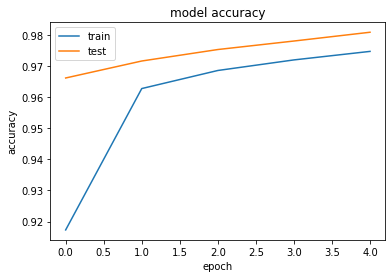

In [11]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('cnn_5_crf_glu_cut_poem_txt_acc.png', dpi=480)
plt.show()

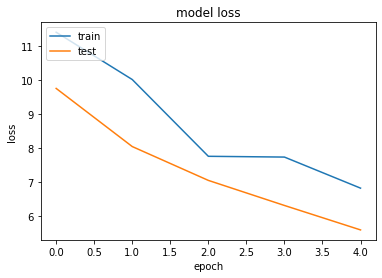

In [12]:
plt.plot(history.history['crf_loss'])
plt.plot(history.history['val_crf_loss_val'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('cnn_5_crf_glu_cut_poem_txt_loss.png', dpi=480)
plt.show()

In [10]:
# with open('cnn_5_crf_glu_cut_poem_txt.json', 'w') as f:
#     json.dump(history.history, f)

## Evaluation

In [13]:
text_proc = Text_Processor('chr2vec_w10_v50.json','cnn_5_crf_glu_cut_poem_txt_epoch40', crf=True, conv_layer=5, conv_chanel=100, kernel=3, dropout_rate=0.2, glu=True)

/Users/benzativit/Library/Python/3.7/lib/python/site-packages/tensorflow/python/autograph/impl/api.py:390: UserWarning: CRF Decoding does not work with KerasTensors in TF2.4. The bug has since been fixed in tensorflow/tensorflow##45534
  return py_builtins.overload_of(f)(*args)


In [14]:
lines = []
with open('test_cut_poem.txt','r', encoding='utf-8') as f:
    s = f.read().split('\n')
    lines.extend(s)

In [15]:
text_proc.get_eval(lines)

{'char_level': {'precision': 0.9695302984165651,
  'recall': 0.9894761562543591,
  'f1': 0.9794016867703618},
 'word_level': {'precision': 0.941122937659174,
  'recall': 0.9604843793315947,
  'f1': 0.9507050930817249}}

## Appiled model to text segmentation task

In [16]:
text_proc = Text_Processor('chr2vec_w10_v50.json','cnn_5_crf_glu_cut_poem_txt_epoch40', crf=True, conv_layer=5, conv_chanel=100, kernel=3, dropout_rate=0.2, glu=True)

In [17]:
text = ['กินข้าวที่ไหนดี?','ไปกินที่ MK มั้ย? หรือจะไปร้านตามสั่ง']
text_proc.word_tagging(text)

['|กิน|ข้าว|ที่|ไหน|ดี|?|',
 '|ไป|กิน|ที่| |MK| |มั้ย|?| |หรือ|จะ|ไป|ร้าน|ตาม|สั่ง|']

In [18]:
text = 'ธนาคารกรุงไทยสร้างปรากฏการณ์ครั้งใหม่ สู้ศึกดิจิทัลในวงการธนาคารไทยที่แข่งขันกันอย่างดุเดือด ด้วยการเปิดตัวบริษัทลูก อินฟินิธัส บาย กรุงไทย จำกัด (Infinitas by Krungthai) ทำการวิจัยและพัฒนาผลิตภัณฑ์ทางการเงินดิจิทัลรูปแบบใหม่'
text_proc.word_tagging(text)

'|ธนาคารกรุงไทย|สร้าง|ปรากฏการณ์|ครั้ง|ใหม่| |สู้|ศึก|ดิจิทัล|ใน|วงการ|ธนาคารไทย|ที่|แข่งขัน|กัน|อย่าง|ดุ|เดือด| |ด้วย|การ|เปิด|ตัว|บริษัท|ลูก| |อินฟินิธัส| |บาย| |กรุงไทย จำกัด| |(|Infinitas| |by| |Krungthai|)| |ทำ|การ|วิจัย|และ|พัฒนา|ผลิตภัณฑ์|ทาง|การ|เงิน|ดิจิทัล|รูปแบบ|ใหม่|'

In [19]:
text = 'ไมโครซอฟท์ประกาศแยกส่วนฟีเจอร์ใหม่ๆ ของ Windows Insider ออกมาเป็น Windows Feature Experience Pack ต่างหาก เพื่อปล่อยอัพเดตผ่าน Windows Update ได้รวดเร็วกว่าเดิม เพราะไม่ต้องรอ Build ใหม่ของ Insider'
text_proc.word_tagging(text)

'|ไมโครซอฟท์|ประกาศ|แยก|ส่วน|ฟีเจอร์|ใหม่|ๆ| |ของ| |Windows| |Insider| |ออก|มา|เป็น| |Windows| |Feature| |Experience| |Pack| |ต่างหาก| |เพื่อ|ปล่อย|อัพเดต|ผ่าน| |Windows| |Update| |ได้|รวดเร็ว|กว่า|เดิม| |เพราะ|ไม่|ต้อง|รอ| |Build| |ใหม่|ของ| |Insider|'

In [20]:
text = 'Zoom รายงานผลประกอบการประจำไตรมาสที่ 3 ตามปีการเงินบริษัท 2021 สิ้นสุดวันที่ 31 ตุลาคม 2020 รายได้รวมเพิ่มขึ้น 367% เทียบกับช่วงเดียวกันในปีก่อนเป็น 777.7 ล้านดอลลาร์ และมีกำไรสุทธิแบบ GAPP 198.4 ล้านดอลลาร์'
text_proc.word_tagging(text)

'|Zoom| |รายงาน|ผล|ประกอบ|การ|ประจำ|ไตรมาส|ที่| |3| |ตาม|ปี|การ|เงิน|บริษัท| |2021| |สิ้นสุด|วัน|ที่| |31| |ตุลาคม| |2020| |ราย|ได้|รวม|เพิ่ม|ขึ้น| |367|%| |เทียบ|กับ|ช่วง|เดียว|กัน|ใน|ปี|ก่อน|เป็น| |777|.|7| |ล้าน|ดอลลาร์| |และ|มี|กำไร|สุทธิ|แบบ| |GAPP| |198|.|4| |ล้าน|ดอลลาร์|'

In [21]:
text = 'Although GLU turns out to be intrinsically simple, the description of GLU from the original paper has been confusing to some of the readers. When I worked on the CycleGAN based voice conversion, I did not implement correctly for the first time. After a few years when I looked back at the paper, I almost misunderstood it again. The official PyTorch GLU function was also very confusing to the users.'
text_proc.word_tagging(text)

'|Although| |GLU| |turns| |out| |to| |be| |intrinsically| |simple|,| |the| |description| |of| |GLU| |from| |the| |original| |paper| |has| |been| |confusing| |to| |some| |of| |the| |readers|.| |When| |I| |worked| |on| |the| |CycleGAN| |based| |voice| |conversion|,| |I| |did| |not| |implement| |correctly| |for| |the| |first| |time|.| |After| |a| |few| |years| |when| |I| |looked| |back| |at| |the| |paper|,| |I| |almost| |misunderstood| |it| |again|.| |The| |official| |PyTorch| |GLU| |function| |was| |also| |very| |confusing| |to| |the| |users|.|'

In [22]:
text = '''กนกคนตลกชวนดวงกมลคนผอมรอชมภมรดมดอมดอกขจรสองคนชอบจอดรถตรงตรอกยอมทนอดนอนอดกรนรอยลภมรดมดอกหอมบนขอนตรงคลอง
มอญลมบนหวนสอบจนปอยผมปรกคอสองสมรสมพรคนจรพบสองอรชรสมพรปองสองสมรยอมลงคลองลอยคอมองสองอรชรมองอกมองคอมองผมมอง
จนสองคนฉงนสมพรบอกชวนสองคนถอนสมอลงชลลองวอนสองหนสองอรชรถอยหลบสมพรวอนจนพลพรรคสดสวยหมดสนกรกนกชวนดวงกมลชงนม
ผงรอชมภมรบนดอนฝนตกตลอดจนถนนปอนจอมปลวกตรงตรอกจอดรถถลอกปอกลงสองสมรมองนกปรอทจกมดจกปลวกจกหนอนลงคอสมพรคงลอย
คอลอยวนบอกสอพลอคนสวยผสมบทสวดของขอมคนหนอคนสมพรสวดวนจนอรชรสองคนฉงนฉงวยงวยงงคอตกยอมนอนลงบนบกสมพรยกซองผงทอง
ปลอมผสมลงนมชงของสองสมรสมพรถอนผมนวลลออสองคนปนผสมตอนหลอมรวมนมชงสมพรสวดบทขอมถอยวกวนหกหนขอวรรคตอนวอนผองชนจง
อวยพรสองดวงสมรรอดปลอดนรกคนคนจรหมอนสกปรกฝนตกจนจอมปลวกยวบลงมดปลวกหนอนออกซอกซอนลงผสมนมชงจนบทสวดหมดผลสมพร
คนสกปรกคงหลงยกนมชงซดลงคอรอครอบครองสองคนสวยปลวกมดหนอนอลวนซอกซอนจนสมพรปวดคองอลงหอนนอนครวญนอนหงอซมบนกอง
หนอนกองปลวกรอหมอตรวจลมฝนสงบลงผองปวงชนพลพรรคครบคนของสองอรชรยกพลสมทบชกถองหวดตบสมพรจนถดถอยตกตมจมลงคลอง'''.replace('\n','')
text_proc.word_tagging(text)

'|กนก|คน|ตลกชวน|ดวง|กมล|คน|ผอม|รอชมภมรดม|ดอม|ดอก|ขจร|สอง|คน|ชอบ|จอด|รถ|ตรง|ตรอก|ยอม|ทนอด|นอน|อด|กรน|รอยลภมรดม|ดอก|หอม|บน|ขอน|ตรง|คลองมอญ|ลม|บน|หวน|สอบ|จน|ปอย|ผม|ปรกคอ|สอง|สมรสมพร|คน|จร|พบ|สอง|อรชรสมพร|ปอง|สอง|สมร|ยอม|ลง|คลองลอย|คอ|มอง|สอง|อรชร|มอง|อก|มอง|คอ|มอง|ผม|มอง|จน|สอง|คน|ฉงนสมพร|บอก|ชวน|สอง|คน|ถอน|สมอ|ลง|ชลลองวอน|สอง|หน|สอง|อรชรถอย|หลบ|สมพร|วอน|จน|พล|พรรค|สด|สวย|หมด|สนกรก|นกชวน|ดวง|กมลชงนม|ผง|รอชมภมร|บนดอน|ฝน|ตก|ตลอดจน|ถนน|ปอน|จอม|ปลวก|ตรง|ตรอก|จอด|รถ|ถลอก|ปอก|ลง|สอง|สมร|มอง|นกปรอท|จ|ก|มดจก|ปลวก|จก|หนอน|ลง|คอสมพร|คง|ลอย|คอ|ลอยวน|บอก|สอ|พลอ|คน|สวย|ผสม|บท|สวด|ของ|ขอม|คน|หนอ|คน|สมพร|สวดวน|จน|อรชร|สอง|คน|ฉงน|ฉงวย|งวย|งงคอ|ตก|ยอม|นอน|ลง|บน|บก|สมพรยก|ซอง|ผง|ทอง|ปลอม|ผสม|ลง|นมชง|ของ|สอง|สมรสมพร|ถอน|ผม|นวล|ลออ|สอง|คน|ปน|ผสม|ตอน|หลอม|รวม|นม|ชงสมพร|สวด|บท|ขอม|ถอย|ว|กวน|หก|หน|ขอ|วรรค|ตอนวอน|ผอง|ชน|จงอวย|พร|สอง|ดวง|สมร|รอด|ปลอด|นรก|คน|คน|จร|หมอน|สกปรก|ฝน|ตก|จน|จอม|ปลวก|ยวบ|ลง|มด|ปลวก|หนอน|ออก|ซอกซอน|ลง|ผสม|นม|ชง|จน|บท|สวด|หมด|ผล|สมพร|คน|สกปรก|คง|หลง|ยก|นม|ชง|ซด|ลง|คอ|รอ|ครอบครอง|สอง|คน|สวย|

In [24]:
text = ['2,000.50 บาท', '50.12%', 'www.blognone.com', 'https://www.blognone.com/node/119894']
text_proc.word_tagging(text)

['|2|,|000|.|50| |บาท|',
 '|50|.|12|%|',
 '|www.blognone.com|',
 '|https://www.blognone.com/node|/|119894|']